In [1]:
#pip install flax

# Imports

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import flax
from flax.training import train_state
import optax

import torch
from torchvision import datasets

import time
import matplotlib.pyplot as plt

# Data

In [3]:
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

In [4]:
batch_size = 2048

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,),
    batch_size=batch_size, shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last = True # because the last one might(does) have the wrong size
    )

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, download=True,),
    batch_size=batch_size, shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last = True
    )


Files already downloaded and verified
Files already downloaded and verified


In [5]:
'''for imgs, sol in train_loader:
    print(imgs.shape)
    break'''
img_size = (32, 32, 3)
num_classes = 10

# Model
I have been experimenting with different versions.

In [6]:
'''
class master_model(flax.linen.Module): 
    @flax.linen.compact
    def __call__(self, x):#size: 32
        x = flax.linen.Conv(features=32, kernel_size=(3, 3))(x)
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 16
        x = flax.linen.Conv(features=64, kernel_size=(3, 3))(x)
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 8
        x = flax.linen.Conv(features=128, kernel_size=(3, 3))(x)
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 4
        x = x.reshape((x.shape[0], -1))  # flatten == 2024
        # print(x.shape) # if not sure
        x = flax.linen.Dense(features=2024)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=512)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=256)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=10)(x)
        x = flax.linen.softmax(x)
        return x
'''


'\nclass master_model(flax.linen.Module): \n    @flax.linen.compact\n    def __call__(self, x):#size: 32\n        x = flax.linen.Conv(features=32, kernel_size=(3, 3))(x)\n        x = flax.linen.relu(x)\n        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 16\n        x = flax.linen.Conv(features=64, kernel_size=(3, 3))(x)\n        x = flax.linen.relu(x)\n        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 8\n        x = flax.linen.Conv(features=128, kernel_size=(3, 3))(x)\n        x = flax.linen.relu(x)\n        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 4\n        x = x.reshape((x.shape[0], -1))  # flatten == 2024\n        # print(x.shape) # if not sure\n        x = flax.linen.Dense(features=2024)(x)\n        x = flax.linen.relu(x)\n        x = flax.linen.Dense(features=512)(x)\n        x = flax.linen.relu(x)\n        x = flax.linen.Dense(features=256)(x)\n        x = flax.linen.relu(x)\n        x = flax.lin

In [7]:
# https://arxiv.org/pdf/1202.2745v1.pdf
# I tried to recreate mcdnn because it was one of the first papers performing really well on this specific dataset
class master_model(flax.linen.Module): 
    @flax.linen.compact
    def __call__(self, x):#size: 32
        x = flax.linen.Conv(features=300, kernel_size=(3, 3), padding="Valid")(x)#30
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#15

        x = flax.linen.Conv(features=300, kernel_size=(2, 2), padding="Valid")(x)#14
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 7

        x = flax.linen.Conv(features=300, kernel_size=(2, 2), padding="Valid")(x)#6
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))#size: 3

        x = flax.linen.Conv(features=300, kernel_size=(2, 2), padding="Valid")(x)#2
        x = flax.linen.relu(x)
        x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="Valid")# 1
        #x = x.reshape((x.shape[0], -1))  # flatten == 2024
        # print(x.shape) # if not sure
        x = flax.linen.Dense(features=300)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=100)(x)
        x = flax.linen.relu(x)
        x = flax.linen.Dense(features=10)(x)
        x = flax.linen.softmax(x)
        return x

# Loss

In [8]:
@jax.jit
def loss_fn(params, inputs, onehot_labels):
    predictions  = master_model().apply({'params': params}, inputs)# you are predicting inside the loss
    
    loss = jnp.mean(jnp.sum(onehot_labels * (1-predictions), axis=-1)) + jnp.mean(jnp.sum(jnp.abs(onehot_labels-1) * predictions, axis=-1))
    return  loss, predictions

# Utility

In [9]:
@jax.jit
def train_step(state, imgs, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=10)
    (loss, predictions), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, imgs, labels_onehot)
    state = state.apply_gradients(grads=grads)  
    metrics = compute_metrics(predictions=predictions, loss=loss, labels=labels)
    return state, metrics

def compute_metrics(*, predictions, loss, labels):
    #one_hot_labels = jax.nn.one_hot(labels, num_classes=10)

    #loss = ... # We already computed the loss, so why do it agin?
    accuracy = jnp.mean(jnp.argmax(predictions, -1) == labels)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

@jax.jit
def eval_step(state, imgs, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=10)
    loss, predictions = loss_fn(state.params, imgs, labels_onehot)
    return compute_metrics(predictions=predictions, loss=loss, labels=labels)

In [10]:
def train_one_epoch(state, dataloader, epoch):
    """Train for 1 epoch on the training set."""
    batch_metrics = []
    for cnt, (imgs, labels) in enumerate(dataloader):
        state, metrics = train_step(state, imgs, labels)
        
        batch_metrics.append(metrics)

    # Aggregate the metrics
    batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return state, epoch_metrics_np


def evaluate_model(state, dataloader):#test set
    batch_metrics = []
    for imgs, labels in dataloader:
        metrics = eval_step(state, imgs, labels)
        batch_metrics.append(metrics)
    
    #Aggregate the metrics
    batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }
    return epoch_metrics_np

In [11]:
#init the model, optimizer etc.
def create_train_state(key, learning_rate, momentum, img_size):
    model = master_model()
    params = model.init(key, jnp.ones([1, *img_size]))['params']
    sgd_opt = optax.sgd(learning_rate, momentum)
    
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=sgd_opt)

# Train

In [12]:
# for some reason, train_state.TrainState.create can only be run once, so you need to restart the notebook if you want to rerun this cell
num_epochs = 1000
lr = optax.linear_schedule(.003 ,.000001, transition_steps=round(num_epochs*.9))
log_epochs = 25
momentum = .7
seed = 42

train_state = create_train_state(jax.random.PRNGKey(seed), lr, momentum, img_size)

In [13]:
test_metrics_dict = {}
start = time.time()
for epoch in range(num_epochs):
    train_state, train_metrics = train_one_epoch(train_state, train_loader, epoch)
    end = time.time()
    
    if epoch % 5 == 0:# don't print every update
      time_since_start = (end-start)/60 # in minutes
      print(f"Train epoch: {epoch+1}, loss: {train_metrics['loss']:.5f}, accuracy: {train_metrics['accuracy']:.5f}, time: {time_since_start:.2f} minutes, estimated runtime: {((time_since_start)/(epoch+1)*num_epochs):.2f} minutes({time_since_start/((time_since_start)/(epoch+1)*num_epochs)*100:.2f}% complete).")

    if epoch % log_epochs == 0:#evaluate method
        test_metrics = evaluate_model(train_state, test_loader)
        print(f"\t\t\t\t---Test epoch: {epoch+1}, loss: {test_metrics['loss']:.5f}, accuracy: {test_metrics['accuracy']:.5f}---")
        test_metrics_dict[epoch+1] = test_metrics

Train epoch: 1, loss: 1.79965, accuracy: 0.10018, time: 0.33 minutes, estimated runtime: 327.84 minutes(0.10% complete).
				---Test epoch: 1, loss: 1.80321, accuracy: 0.09839---
Train epoch: 6, loss: 1.79981, accuracy: 0.10010, time: 1.44 minutes, estimated runtime: 240.44 minutes(0.60% complete).
Train epoch: 11, loss: 1.79977, accuracy: 0.10012, time: 2.47 minutes, estimated runtime: 224.98 minutes(1.10% complete).
Train epoch: 16, loss: 1.80013, accuracy: 0.09994, time: 3.50 minutes, estimated runtime: 218.71 minutes(1.60% complete).
Train epoch: 21, loss: 1.79989, accuracy: 0.10006, time: 4.54 minutes, estimated runtime: 216.01 minutes(2.10% complete).
Train epoch: 26, loss: 1.80001, accuracy: 0.10000, time: 5.56 minutes, estimated runtime: 214.02 minutes(2.60% complete).
				---Test epoch: 26, loss: 1.80126, accuracy: 0.09937---
Train epoch: 31, loss: 1.80017, accuracy: 0.09991, time: 6.60 minutes, estimated runtime: 212.92 minutes(3.10% complete).
Train epoch: 36, loss: 1.80001,

In [1]:
# sound when finished
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')


# Visualisations

In [ ]:
x = sorted(test_metrics_dict.keys())
y = [test_metrics_dict[key]["loss"] for key in x]
plt.plot(x,y)
plt.title("Loss Progression")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

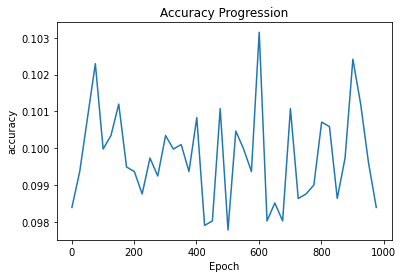

In [16]:
x = sorted(test_metrics_dict.keys())
y = [test_metrics_dict[key]["accuracy"] for key in x]
plt.plot(x,y)
plt.title("Accuracy Progression")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.show()